        date      NDVI      NDWI      GVMI  SoilMoisture_0.3m  temperature  \
0 2017-11-14  0.281545 -0.099993  0.091193           0.152292         3.57   
1 2017-11-14  0.281586 -0.099988  0.090987           0.152292         3.57   
2 2017-11-17  0.449859 -0.041480  0.243278           0.150417         6.12   
3 2017-11-17  0.449870 -0.041596  0.243501           0.150417         6.12   
4 2017-11-22  0.402998 -0.062142  0.229818           0.151375         8.86   

   precipitation  irradiation  humidity  wind_speed  ...  irradiation_t+2  \
0           0.00         9.80     82.50        4.89  ...             9.10   
1           0.00         9.80     82.50        4.89  ...             9.10   
2           0.00         9.30     75.19        2.72  ...             8.41   
3           0.00         9.30     75.19        2.72  ...             8.41   
4           0.01         8.98     82.88        4.89  ...             5.25   

   humidity_t+2  wind_speed_t+2  pressure_t+2  temperature_t+3  \
0 

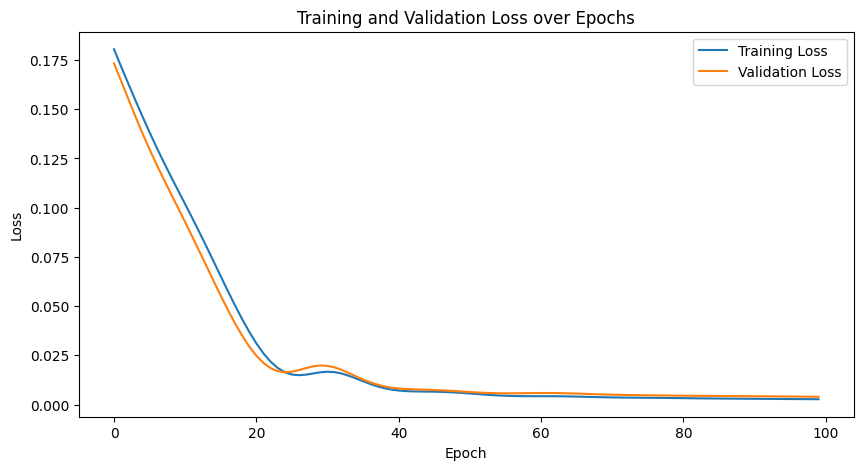

          Date  Predicted_SoilMoisture  Irrigate
0   2017-11-14                0.267548     False
1   2017-11-14                0.209616      True
2   2017-11-17                0.220922      True
3   2017-11-17                0.197027      True
4   2017-11-22                0.258673     False
..         ...                     ...       ...
161 2019-01-21                0.238387     False
162 2019-02-12                0.265717     False
163 2019-02-12                0.123256      True
164 2019-02-15                0.346988     False
165 2019-02-15                0.250583     False

[166 rows x 3 columns]


In [27]:
from google.oauth2 import service_account
import ee
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import requests

# Initialize Earth Engine API
service_account_key = r'C:\Users\serafino\Desktop\Water Management System\ee-eugenioserafino01-dca7dda5348b.json'

scopes = ['https://www.googleapis.com/auth/earthengine']
credentials = service_account.Credentials.from_service_account_file(
    service_account_key, scopes=scopes
)
ee.Initialize(credentials=credentials)

# Define area coordinates
train_field_coordinates_SFL = [
    [1.8798637390136719, 43.44159337074114],
    [1.8803036212921145, 43.44159337074114],
    [1.8798637390136719, 43.44181927878505],
    [1.8803036212921145, 43.44181927878505],
]

days_before_today = 2555
forecast_days = 3

# Fetch Sentinel-2 data

def get_sentinel2_indices(polygon_coordinates, days_before_today):
    """
    Fetches Sentinel-2 indices (e.g., NDVI, NDWI, GVMI) without including raw bands.
    """
    end_date = datetime.today()
    start_date = end_date - timedelta(days=days_before_today)
    start_date_str = start_date.strftime('%Y-%m-%d')
    end_date_str = end_date.strftime('%Y-%m-%d')
    
    # Define polygon geometry
    location_polygon = ee.Geometry.Polygon([polygon_coordinates])

    # Load Sentinel-2 image collection with date and cloud filter
    collection = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
                  .filterDate(start_date_str, end_date_str)
                  .filterBounds(location_polygon)
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50))
                  .map(lambda image: image.select()
                       .addBands(image.normalizedDifference(['B8', 'B4']).rename('NDVI'))
                       .addBands(image.normalizedDifference(['B8', 'B11']).rename('NDWI'))
                       .addBands(image.expression(
                           '((NIR + 0.1) - (SWIR2 + 0.02)) / ((NIR + 0.1) + (SWIR2 + 0.02))', 
                           {'NIR': image.select('B8'), 'SWIR2': image.select('B12')}
                       ).rename('GVMI'))))
    
    # Reduce to daily mean for each index
    collection_data = collection.map(lambda image: ee.Feature(None, image.reduceRegion(
        reducer=ee.Reducer.mean(), geometry=location_polygon, scale=10, maxPixels=1e9)
        .set('date', image.date().format('YYYY-MM-dd'))))

    # Convert to pandas DataFrame
    indices_data = ee.FeatureCollection(collection_data).getInfo()['features']
    df = pd.DataFrame([
        {**feature['properties'], 'date': pd.to_datetime(feature['properties']['date'])} 
        for feature in indices_data
    ])
    
    # Keep only the columns corresponding to indices and date
    df = df[['date', 'NDVI', 'NDWI', 'GVMI']]
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    df.interpolate(method='time', inplace=True)
    df.dropna(inplace=True)
    
    return df.reset_index()

# Function to fetch weather data including forecasts
def get_weather_data(polygon_coordinates, days_before_today, forecast_days=3):
    """
    Fetches historical and forecasted weather data and creates shifted features.
    """
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days_before_today)
    start_date_str = start_date.strftime('%Y%m%d')
    end_date_str = end_date.strftime('%Y%m%d')
    
    lon = np.mean([point[0] for point in polygon_coordinates])
    lat = np.mean([point[1] for point in polygon_coordinates])
    parameters = "T2M,PRECTOTCORR,ALLSKY_SFC_SW_DWN,RH2M,WS10M,PS"
    
    # Fetch historical weather data
    nasa_power_url_hist = (
        f"https://power.larc.nasa.gov/api/temporal/daily/point?parameters={parameters}"
        f"&community=AG&longitude={lon}&latitude={lat}"
        f"&start={start_date_str}&end={end_date_str}&format=JSON"
    )
    response_hist = requests.get(nasa_power_url_hist)
    weather_data_hist = response_hist.json()["properties"]["parameter"]
    
    # Parse historical data into DataFrame
    dates_hist = list(weather_data_hist["T2M"].keys())
    weather_df_hist = pd.DataFrame({
        'date': pd.to_datetime(dates_hist, format='%Y%m%d'),
        'temperature': list(weather_data_hist["T2M"].values()),
        'precipitation': list(weather_data_hist["PRECTOTCORR"].values()),
        'irradiation': list(weather_data_hist["ALLSKY_SFC_SW_DWN"].values()),
        'humidity': list(weather_data_hist["RH2M"].values()),
        'wind_speed': list(weather_data_hist["WS10M"].values()),
        'pressure': list(weather_data_hist["PS"].values())
    })

    # Data preprocessing
    weather_df_hist.replace(-999.00, np.nan, inplace=True)
    weather_df_hist.set_index('date', inplace=True)
    weather_df_hist.sort_index(inplace=True)
    weather_df_hist.interpolate(method='time', inplace=True)
    weather_df_hist.dropna(inplace=True)
    weather_df_hist.reset_index(inplace=True)
    
    # Create shifted features for forecast days
    for i in range(1, forecast_days + 1):
        weather_df_hist[f'temperature_t+{i}'] = weather_df_hist['temperature'].shift(-i)
        weather_df_hist[f'precipitation_t+{i}'] = weather_df_hist['precipitation'].shift(-i)
        weather_df_hist[f'irradiation_t+{i}'] = weather_df_hist['irradiation'].shift(-i)
        weather_df_hist[f'humidity_t+{i}'] = weather_df_hist['humidity'].shift(-i)
        weather_df_hist[f'wind_speed_t+{i}'] = weather_df_hist['wind_speed'].shift(-i)
        weather_df_hist[f'pressure_t+{i}'] = weather_df_hist['pressure'].shift(-i)

    weather_df_hist = weather_df_hist.iloc[:-forecast_days]
    return weather_df_hist

# Usage of functions
train_field_coordinates_SFL = [
    [1.8798637390136719, 43.44159337074114],
    [1.8803036212921145, 43.44159337074114],
    [1.8798637390136719, 43.44181927878505],
    [1.8803036212921145, 43.44181927878505],
]
days_before_today = 2555
forecast_days = 3

sentinel2_indices_df = get_sentinel2_indices(train_field_coordinates_SFL, days_before_today)
weather_df = get_weather_data(train_field_coordinates_SFL, days_before_today, forecast_days)

# Load soil moisture data with absolute values (not normalized)
target_df = pd.read_csv(r'C:\Users\serafino\Desktop\Water Management System\train_data_sm_0.3m.csv')
target_df.rename(columns={'DateTime': 'date'}, inplace=True)
target_df['date'] = pd.to_datetime(target_df['date'])

# Ensure all DataFrames are aligned by date before merging
sentinel2_indices_df['date'] = pd.to_datetime(sentinel2_indices_df['date'])
weather_df['date'] = pd.to_datetime(weather_df['date'])

# Merge all data by date
data = (sentinel2_indices_df
        .merge(target_df[['date', 'SoilMoisture_0.3m']], on='date', how='inner')
        .merge(weather_df, on='date', how='inner')
        .dropna())

# Display merged DataFrame
print(data.head())
# Define features and target
X = data.drop(columns=['date', 'SoilMoisture_0.3m']).values
y = data['SoilMoisture_0.3m'].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

# Neural Network model
class SoilMoistureNN(nn.Module):
    def __init__(self, input_size):
        super(SoilMoistureNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.output(x)

# Initialize model
input_size = X_train.shape[1]
model = SoilMoistureNN(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_losses.append(val_loss.item())
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.show()

# Calculate field capacity and irrigation threshold
percentile_value = 95
field_capacity = np.percentile(data['SoilMoisture_0.3m'], percentile_value)
FTSW_thresh = 0.7
VWC_thresh = FTSW_thresh * field_capacity

# Predict on validation set
model.eval()
with torch.no_grad():
    y_val_pred = model(X_val_tensor).numpy().flatten()

# Prepare output with irrigation suggestion
val_results = pd.DataFrame({
    'Date': data['date'].iloc[y_val_tensor.squeeze().argsort()].values,
    'Predicted_SoilMoisture': y_val_pred,
    'Irrigate': y_val_pred < VWC_thresh
}).sort_values(by='Date').reset_index(drop=True)

print(val_results)


C:\Users\serafino\AppData\Local\Temp\ipykernel_11708\2199179660.py:129: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  weather_df_full = pd.concat([weather_df_hist, weather_df_forecast])


Epoch 1/100, Train Loss: 0.2483, Val Loss: 0.2377
Epoch 2/100, Train Loss: 0.2372, Val Loss: 0.2274
Epoch 3/100, Train Loss: 0.2268, Val Loss: 0.2176
Epoch 4/100, Train Loss: 0.2170, Val Loss: 0.2084
Epoch 5/100, Train Loss: 0.2077, Val Loss: 0.1997
Epoch 6/100, Train Loss: 0.1990, Val Loss: 0.1915
Epoch 7/100, Train Loss: 0.1908, Val Loss: 0.1839
Epoch 8/100, Train Loss: 0.1831, Val Loss: 0.1767
Epoch 9/100, Train Loss: 0.1758, Val Loss: 0.1696
Epoch 10/100, Train Loss: 0.1686, Val Loss: 0.1624
Epoch 11/100, Train Loss: 0.1613, Val Loss: 0.1551
Epoch 12/100, Train Loss: 0.1540, Val Loss: 0.1476
Epoch 13/100, Train Loss: 0.1465, Val Loss: 0.1399
Epoch 14/100, Train Loss: 0.1387, Val Loss: 0.1320
Epoch 15/100, Train Loss: 0.1307, Val Loss: 0.1239
Epoch 16/100, Train Loss: 0.1224, Val Loss: 0.1155
Epoch 17/100, Train Loss: 0.1139, Val Loss: 0.1069
Epoch 18/100, Train Loss: 0.1051, Val Loss: 0.0982
Epoch 19/100, Train Loss: 0.0962, Val Loss: 0.0894
Epoch 20/100, Train Loss: 0.0872, Val Lo

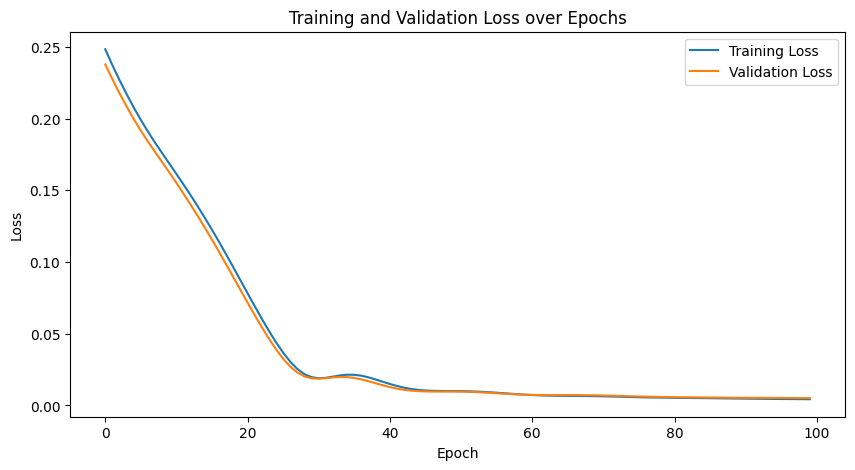

Validation RMSE: 0.0713
Validation MAE: 0.0527
Validation R2 Score: 0.0032
        Date  Predicted_SoilMoisture  Irrigate       date  \
0 2024-10-29                0.508439     False 2024-10-29   
1 2024-11-03                0.521535     False 2024-11-03   

   Total_Precipitation_Next_3_Days    Suggest  
0                              0.0  No Action  
1                              0.0  No Action  


C:\Users\serafino\AppData\Local\Temp\ipykernel_11708\2199179660.py:129: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  weather_df_full = pd.concat([weather_df_hist, weather_df_forecast])
C:\Users\serafino\AppData\Local\Temp\ipykernel_11708\2199179660.py:282: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will 

In [31]:
import ee
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import requests
from google.oauth2 import service_account
import joblib


# Fetch Sentinel-2 indices
def get_sentinel2_indices(polygon_coordinates, days_before_today):
    end_date = datetime.today()
    start_date = end_date - timedelta(days=days_before_today)
    start_date_str = start_date.strftime('%Y-%m-%d')
    end_date_str = end_date.strftime('%Y-%m-%d')
    
    location_polygon = ee.Geometry.Polygon([polygon_coordinates])

    collection = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
                  .filterDate(start_date_str, end_date_str)
                  .filterBounds(location_polygon)
                  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50))
                  .map(lambda image: image.select()
                       .addBands(image.normalizedDifference(['B8', 'B4']).rename('NDVI'))
                       .addBands(image.normalizedDifference(['B8', 'B11']).rename('NDWI'))
                       .addBands(image.expression(
                           '((NIR + 0.1) - (SWIR2 + 0.02)) / ((NIR + 0.1) + (SWIR2 + 0.02))', 
                           {'NIR': image.select('B8'), 'SWIR2': image.select('B12')}
                       ).rename('GVMI'))))

    collection_data = collection.map(lambda image: ee.Feature(None, image.reduceRegion(
        reducer=ee.Reducer.mean(), geometry=location_polygon, scale=10, maxPixels=1e9)
        .set('date', image.date().format('YYYY-MM-dd'))))

    indices_data = ee.FeatureCollection(collection_data).getInfo()['features']
    df = pd.DataFrame([
        {**feature['properties'], 'date': pd.to_datetime(feature['properties']['date'])} 
        for feature in indices_data
    ])
    df = df[['date', 'NDVI', 'NDWI', 'GVMI']]
    df.set_index('date', inplace=True)
    df.sort_index(inplace=True)
    df.interpolate(method='time', inplace=True)
    df.dropna(inplace=True)
    return df.reset_index()

# Fetch weather data including forecasts
def get_forecast_weather_data(polygon_coordinates, forecast_days=3):
    lon = np.mean([point[0] for point in polygon_coordinates])
    lat = np.mean([point[1] for point in polygon_coordinates])
    parameters = "T2M,PRECTOTCORR,ALLSKY_SFC_SW_DWN,RH2M,WS10M,PS"

    start_date = datetime.now()
    end_date = start_date + timedelta(days=forecast_days)
    start_date_str = start_date.strftime('%Y%m%d')
    end_date_str = end_date.strftime('%Y%m%d')

    nasa_power_url_forecast = (
        f"https://power.larc.nasa.gov/api/temporal/daily/point?parameters={parameters}"
        f"&community=AG&longitude={lon}&latitude={lat}"
        f"&start={start_date_str}&end={end_date_str}&format=JSON&forecast=true"
    )

    response_forecast = requests.get(nasa_power_url_forecast)
    forecast_data = response_forecast.json()["properties"]["parameter"]

    dates_forecast = list(forecast_data["T2M"].keys())
    weather_df_forecast = pd.DataFrame({
        'date': pd.to_datetime(dates_forecast, format='%Y%m%d'),
        'temperature': list(forecast_data["T2M"].values()),
        'precipitation': list(forecast_data["PRECTOTCORR"].values()),
        'irradiation': list(forecast_data["ALLSKY_SFC_SW_DWN"].values()),
        'humidity': list(forecast_data["RH2M"].values()),
        'wind_speed': list(forecast_data["WS10M"].values()),
        'pressure': list(forecast_data["PS"].values())
    })
    weather_df_forecast.replace(-999.00, np.nan, inplace=True)
    weather_df_forecast.set_index('date', inplace=True)
    weather_df_forecast.sort_index(inplace=True)
    weather_df_forecast.interpolate(method='time', inplace=True)
    weather_df_forecast.dropna(inplace=True)
    weather_df_forecast.reset_index(inplace=True)
    return weather_df_forecast

def get_weather_data(polygon_coordinates, days_before_today, forecast_days=3):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days_before_today)
    start_date_str = start_date.strftime('%Y%m%d')
    end_date_str = end_date.strftime('%Y%m%d')
    
    lon = np.mean([point[0] for point in polygon_coordinates])
    lat = np.mean([point[1] for point in polygon_coordinates])
    parameters = "T2M,PRECTOTCORR,ALLSKY_SFC_SW_DWN,RH2M,WS10M,PS"
    
    nasa_power_url_hist = (
        f"https://power.larc.nasa.gov/api/temporal/daily/point?parameters={parameters}"
        f"&community=AG&longitude={lon}&latitude={lat}"
        f"&start={start_date_str}&end={end_date_str}&format=JSON"
    )
    response_hist = requests.get(nasa_power_url_hist)
    weather_data_hist = response_hist.json()["properties"]["parameter"]
    
    dates_hist = list(weather_data_hist["T2M"].keys())
    weather_df_hist = pd.DataFrame({
        'date': pd.to_datetime(dates_hist, format='%Y%m%d'),
        'temperature': list(weather_data_hist["T2M"].values()),
        'precipitation': list(weather_data_hist["PRECTOTCORR"].values()),
        'irradiation': list(weather_data_hist["ALLSKY_SFC_SW_DWN"].values()),
        'humidity': list(weather_data_hist["RH2M"].values()),
        'wind_speed': list(weather_data_hist["WS10M"].values()),
        'pressure': list(weather_data_hist["PS"].values())
    })
    weather_df_hist.replace(-999.00, np.nan, inplace=True)
    weather_df_hist.set_index('date', inplace=True)
    weather_df_hist.sort_index(inplace=True)
    weather_df_hist.interpolate(method='time', inplace=True)
    weather_df_hist.dropna(inplace=True)
    weather_df_hist.reset_index(inplace=True)
    
    weather_df_forecast = get_forecast_weather_data(polygon_coordinates, forecast_days)
    weather_df_forecast.set_index('date', inplace=True)
    weather_df_full = pd.concat([weather_df_hist, weather_df_forecast])
    weather_df_full.sort_index(inplace=True)
    weather_df_full.reset_index(inplace=True)
    
    for i in range(1, forecast_days + 1):
        weather_df_full[f'temperature_t+{i}'] = weather_df_full['temperature'].shift(-i)
        weather_df_full[f'precipitation_t+{i}'] = weather_df_full['precipitation'].shift(-i)
        weather_df_full[f'irradiation_t+{i}'] = weather_df_full['irradiation'].shift(-i)
        weather_df_full[f'humidity_t+{i}'] = weather_df_full['humidity'].shift(-i)
        weather_df_full[f'wind_speed_t+{i}'] = weather_df_full['wind_speed'].shift(-i)
        weather_df_full[f'pressure_t+{i}'] = weather_df_full['pressure'].shift(-i)
    weather_df_full = weather_df_full.iloc[:-forecast_days]
    return weather_df_full

# Load and prepare training data
train_field_coordinates = [
    [1.8798637390136719, 43.44159337074114],
    [1.8803036212921145, 43.44159337074114],
    [1.8798637390136719, 43.44181927878505],
    [1.8803036212921145, 43.44181927878505],
]
days_before_today = 2555
forecast_days = 3

sentinel2_indices_df = get_sentinel2_indices(train_field_coordinates, days_before_today)
weather_df = get_weather_data(train_field_coordinates, days_before_today, forecast_days)

target_df = pd.read_csv(r'C:\Users\serafino\Desktop\Water Management System\train_data_sm_0.3m.csv')
target_df.rename(columns={'DateTime': 'date'}, inplace=True)
target_df['date'] = pd.to_datetime(target_df['date'])

sentinel2_indices_df['date'] = pd.to_datetime(sentinel2_indices_df['date'])
weather_df['date'] = pd.to_datetime(weather_df['date'])

data = (sentinel2_indices_df
        .merge(target_df[['date', 'SoilMoisture_0.3m']], on='date', how='inner')
        .merge(weather_df, on='date', how='inner')
        .dropna())

# Define features and target
X = data.drop(columns=['date', 'SoilMoisture_0.3m']).values
y = data['SoilMoisture_0.3m'].values

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

# Neural Network model
class SoilMoistureNN(nn.Module):
    def __init__(self, input_size):
        super(SoilMoistureNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.output(x)

# Initialize model
input_size = X_train.shape[1]
model = SoilMoistureNN(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_losses.append(val_loss.item())
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss over Epochs')
plt.show()

# Calculate field capacity and irrigation threshold
percentile_value = 95
field_capacity = np.percentile(data['SoilMoisture_0.3m'], percentile_value)
FTSW_thresh = 0.7
VWC_thresh = FTSW_thresh * field_capacity

# Predict on validation set
model.eval()
with torch.no_grad():
    y_val_pred = model(X_val_tensor).numpy().flatten()

# Compute metrics on validation set
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
val_mae = mean_absolute_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f'Validation RMSE: {val_rmse:.4f}')
print(f'Validation MAE: {val_mae:.4f}')
print(f'Validation R2 Score: {val_r2:.4f}')

# Save the model and scaler
torch.save(model.state_dict(), 'soil_moisture_model.pth')
joblib.dump(scaler, 'scaler.pkl')

# Function to predict soil moisture for new coordinates
def get_data_for_prediction(polygon_coordinates, days_before_today, forecast_days):
    sentinel2_indices_df = get_sentinel2_indices(polygon_coordinates, days_before_today)
    weather_df = get_weather_data(polygon_coordinates, days_before_today, forecast_days)
    sentinel2_indices_df['date'] = pd.to_datetime(sentinel2_indices_df['date'])
    weather_df['date'] = pd.to_datetime(weather_df['date'])
    data = (sentinel2_indices_df
            .merge(weather_df, on='date', how='inner')
            .dropna())
    return data

def predict_soil_moisture(polygon_coordinates):
    days_before_today = 30
    forecast_days = 3
    data = get_data_for_prediction(polygon_coordinates, days_before_today, forecast_days)
    X_new = data.drop(columns=['date']).values
    scaler = joblib.load('scaler.pkl')
    X_new_scaled = scaler.transform(X_new)
    X_new_tensor = torch.tensor(X_new_scaled, dtype=torch.float32)
    input_size = X_new.shape[1]
    model = SoilMoistureNN(input_size)
    model.load_state_dict(torch.load('soil_moisture_model.pth'))
    model.eval()
    with torch.no_grad():
        y_pred = model(X_new_tensor).numpy().flatten()
    results = pd.DataFrame({
        'Date': data['date'],
        'Predicted_SoilMoisture': y_pred
    })
    percentile_value = 95
    field_capacity = np.percentile(target_df['SoilMoisture_0.3m'], percentile_value)
    FTSW_thresh = 0.7
    VWC_thresh = FTSW_thresh * field_capacity
    results['Irrigate'] = results['Predicted_SoilMoisture'] < VWC_thresh
    forecast_precipitation = data[['date', 'precipitation_t+1', 'precipitation_t+2', 'precipitation_t+3']]
    forecast_precipitation['Total_Precipitation_Next_3_Days'] = forecast_precipitation[['precipitation_t+1', 'precipitation_t+2', 'precipitation_t+3']].sum(axis=1)
    results = results.merge(forecast_precipitation[['date', 'Total_Precipitation_Next_3_Days']], left_on='Date', right_on='date', how='left')
    results['Suggest'] = results.apply(lambda row: 'Wait' if row['Total_Precipitation_Next_3_Days'] > 5 else ('Irrigate' if row['Irrigate'] else 'No Action'), axis=1)
    return results

# Example usage with new coordinates
new_coordinates = [
    [12.021280, 45.251061],
    [12.021719, 45.250949],
    [12.022229, 45.251746],
    [12.022891, 45.251549],
    [12.023380, 45.252315],
    [12.023846, 45.252183],
    [12.024085, 45.252617],
    [12.022100, 45.252718],
    [12.021280, 45.251061]  # Closing the polygon by repeating the first point
]

results = predict_soil_moisture(new_coordinates)
print(results)
